## Biophysical branching model

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of branching model by simulating nutrient diffusion and density-dependent diffusion of cell dispersal.


In [13]:
%reset -f
# Import numerical jax dependencies
import jax
from jax import numpy as jnp
from jax import vmap

# For readability. 
from collections import namedtuple

# Import plotting dependencies
import matplotlib.pyplot as plt
from jax_tqdm import scan_tqdm
from IPython.display import clear_output
import time


##### PDE Update
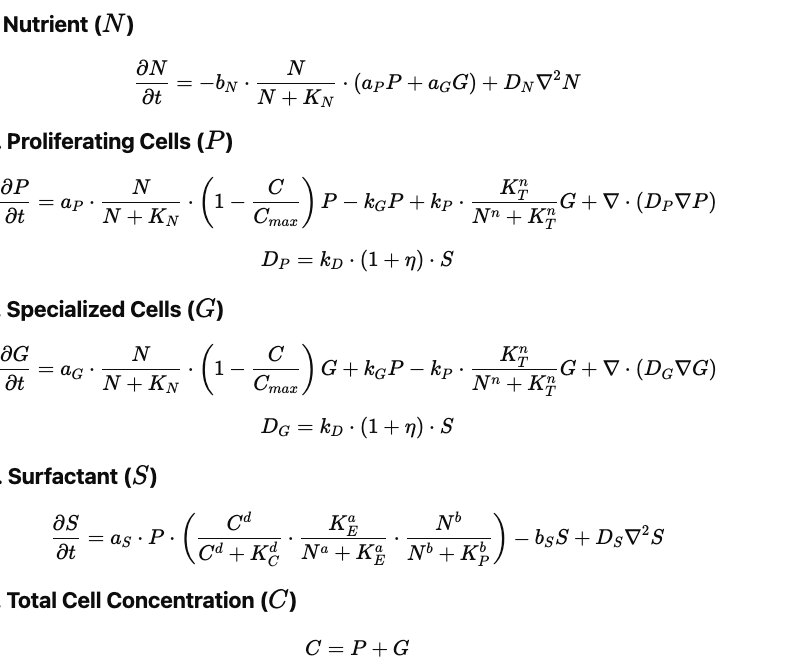

In [14]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import os
import numpy as np

def initialize_fields(nx, ny, Lx, Ly, N0, C0, R0):
    """
    Initializes the fields N, P, G, S.
    
    Parameters:
    - nx, ny: Grid dimensions.
    - Lx, Ly: Physical domain sizes.
    - N0: Initial nutrient concentration.
    - C0: Initial cell concentration at the center.
    - R0: Radius for initial cell concentration.
    
    Returns:
    - Tuple of (N_initial, P_initial, G_initial, S_initial)
    """
    x = jnp.linspace(0, Lx, nx, endpoint=False)
    y = jnp.linspace(0, Ly, ny, endpoint=False)
    X, Y = jnp.meshgrid(x, y, indexing='ij')
    
    # Initialize Nutrient N uniformly
    N_initial = jnp.full((nx, ny), N0)
    
    # Initialize P and G
    P_initial = jnp.zeros((nx, ny))
    G_initial = C0 * jnp.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2))
 
     
    # Initialize S as zero
    S_initial = jnp.zeros((nx, ny))
    
    return N_initial, P_initial, G_initial, S_initial

@jit
def laplacian(U, dx, dy):
    """
    Computes the Laplacian of a 2D field using central differences.

    Parameters:
    - U: 2D array.
    - dx, dy: Spatial step sizes.

    Returns:
    - Laplacian of U.
    """
    U_padded = jnp.pad(U, pad_width=1, mode='edge')
    laplacian_U = (
        (U_padded[2:, 1:-1] - 2 * U + U_padded[:-2, 1:-1]) / dx**2 +
        (U_padded[1:-1, 2:] - 2 * U + U_padded[1:-1, :-2]) / dy**2
    )
    return laplacian_U


@jit

def diffusion_operator(U, D, dx):
    """
    Computes the diffusion term ∇·(D ∇U) for a 2D field U with variable diffusivity D,
    implementing Neumann (zero-flux) boundary conditions.

    Parameters:
    - U: 2D array representing the concentration of a species (P or G).
    - D: 2D array representing the diffusivity at each grid point.
    - dx: Spatial step size (assumed equal in x and y).

    Returns:
    - diffusion: 2D array of the same shape as U representing ∇·(D ∇U).
    """
    # Pad U and D with edge values to implement Neumann boundary conditions
    U_padded = jnp.pad(U, pad_width=1, mode='edge')
    D_padded = jnp.pad(D, pad_width=1, mode='edge')

    # Compute finite differences
    # ∇U
    dU_dx = (U_padded[2:, 1:-1] - U_padded[:-2, 1:-1]) / (2 * dx)
    dU_dy = (U_padded[1:-1, 2:] - U_padded[1:-1, :-2]) / (2 * dx)

    # ∇D
    dD_dx = (D_padded[2:, 1:-1] - D_padded[:-2, 1:-1]) / (2 * dx)
    dD_dy = (D_padded[1:-1, 2:] - D_padded[1:-1, :-2]) / (2 * dx)

    # Compute ∇·(D ∇U) = D ∇²U + ∇D · ∇U
    laplacian_U = (U_padded[2:, 1:-1] - 2 * U + U_padded[:-2, 1:-1]) / dx**2 + \
                 (U_padded[1:-1, 2:] - 2 * U + U_padded[1:-1, :-2]) / dx**2

    diffusion = D * laplacian_U + dD_dx * dU_dx + dD_dy * dU_dy

    return diffusion






In [15]:
@jit
def pde_update_fdm(pde_state, pde_params, dx, dy, dt, noise):
    """
    Corrected finite difference update for N, P, G, S with proper ∇·(D * ∇U) diffusion terms
    and Neumann boundary conditions.

    Parameters:
    - pde_state: Tuple of current states (N, P, G, S).
    - pde_params: Tuple of parameters (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP).
    - dx, dy: Spatial step sizes (assumed equal).
    - dt: Time step size.
    - noise: 2D array of noise to inject into D_eff.

    Returns:
    - Updated state (N_new, P_new, G_new, S_new), None
    """
    N, P, G, S = pde_state
    (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP) = pde_params

    C = P + G

    # Reaction Terms
    fG = (N / (N + KN)) * (1 - C / Cmax)
    dN = -bN * fG * (aP * P + aG * G)
    fT = (KT ** n) / (N ** n + KT ** n)
    dP = aP * fG * P - kG * P + kP * fT * G
    dG = aG * fG * G + kG * P - kP * fT * G
    fQS = (C ** d) / (C ** d + KC ** d)
    fE = (KE ** a) / (N ** a + KE ** a)
    fP = (N ** b) / (N ** b + KP ** b)
    f = fQS * fE * fP
    dS = aS * P * f - bS * S

    # Compute variable diffusivities
    D_P = kD * (1 + noise) * S
    D_P = jnp.clip(D_P, 0, None)
    D_G = kD * (1 + noise) * S
    D_G = jnp.clip(D_G, 0, None)

    # Compute diffusion terms using the corrected operator with Neumann BC
    diffusion_N = DN * laplacian(N, dx, dy)  # Assuming DN is constant
    diffusion_S = DS * laplacian(S, dx, dy)  # Assuming DS is constant

    diffusion_P = diffusion_operator(P, D_P, dx)
    diffusion_G = diffusion_operator(G, D_G, dx)

    # Update equations using Explicit Euler Scheme
    N_new = N + dt * (dN + diffusion_N)
    P_new = P + dt * (dP + diffusion_P)
    G_new = G + dt * (dG + diffusion_G)
    S_new = S + dt * (dS + diffusion_S)

    # Ensure Non-Negativity
    N_new = jnp.clip(N_new, 0, None)
    P_new = jnp.clip(P_new, 0, None)
    G_new = jnp.clip(G_new, 0, None)
    S_new = jnp.clip(S_new, 0, None)

    return (N_new, P_new, G_new, S_new), None


[5, 0.2, 1000.0, 15, 24.24, 8.67, 75.36, 16.98, 0.64, 6.45, 30, 5, 6.08, 4.55, 20, 2, 2.205, 1.69, 1.84, 2.06, 6, 1.0]


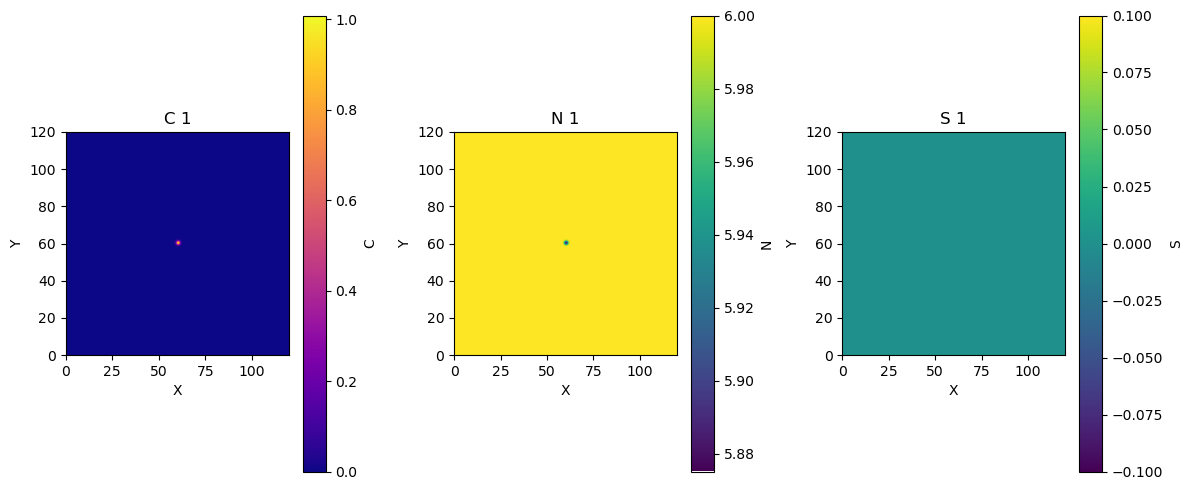

Step 0: Time = 0.0000, Colony Radius = 2.1363


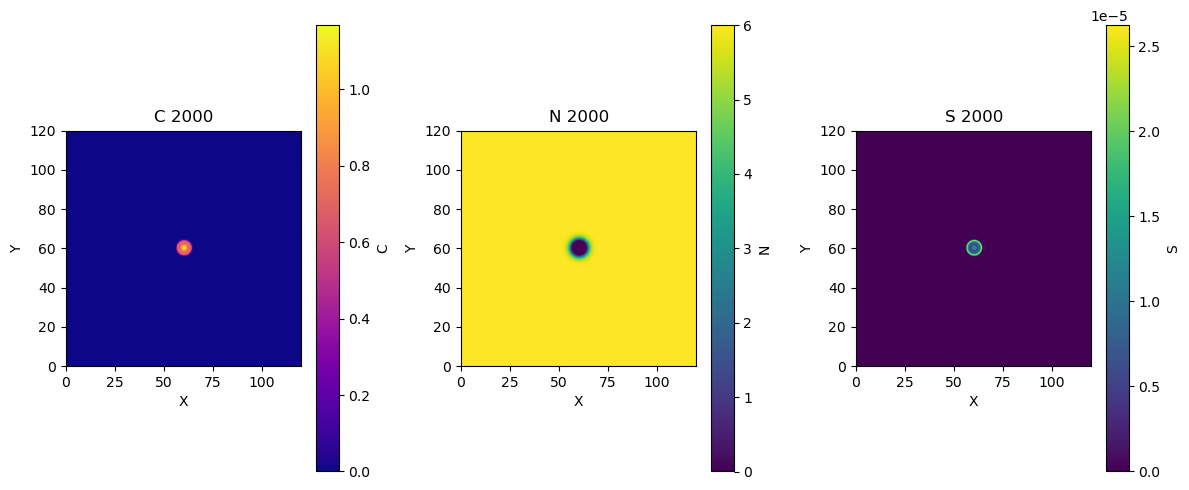

Step 1999: Time = 0.7996, Colony Radius = 4.5056


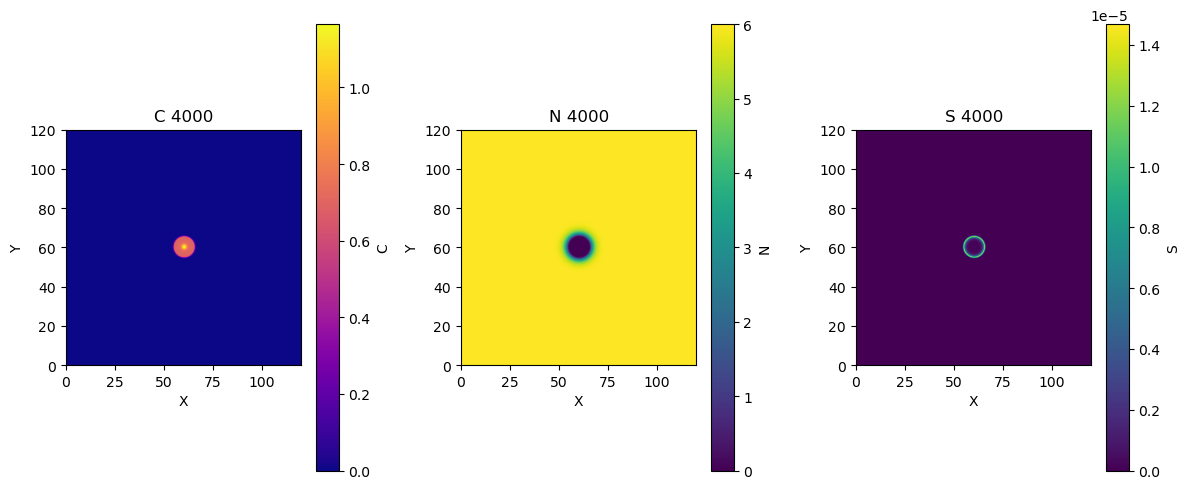

Step 3999: Time = 1.5996, Colony Radius = 5.9504


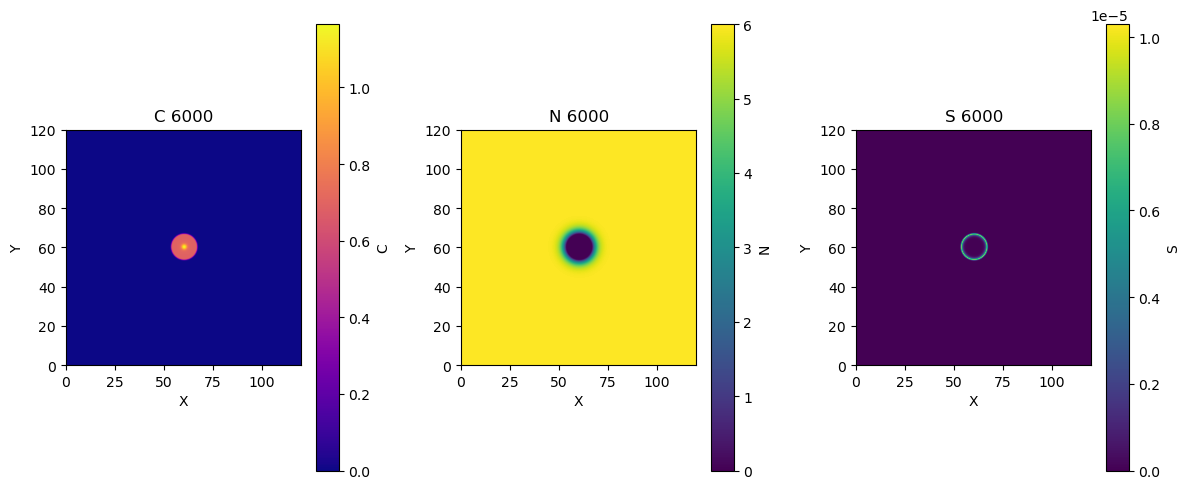

Step 5999: Time = 2.3996, Colony Radius = 7.1025


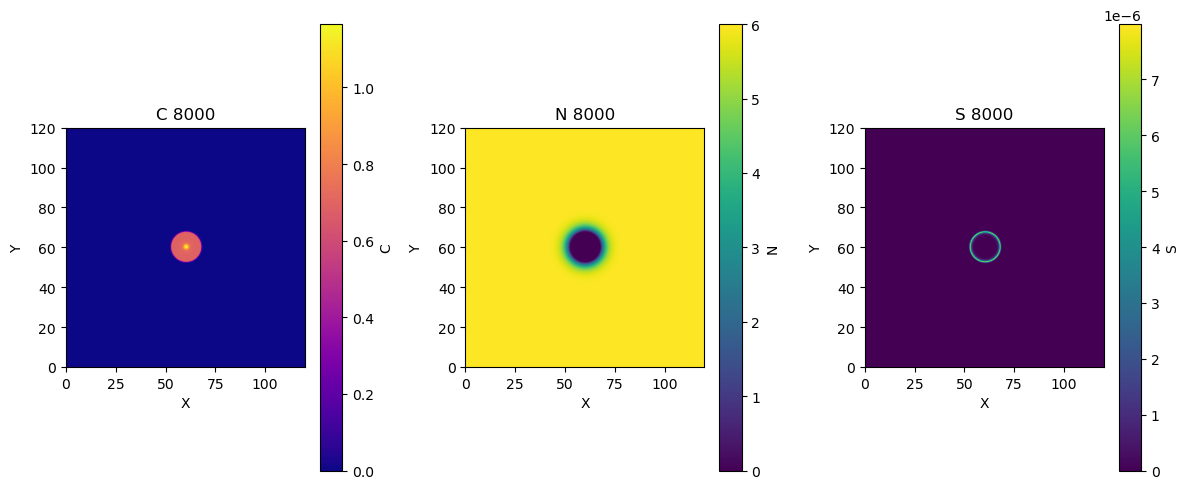

Step 7999: Time = 3.1996, Colony Radius = 8.0921


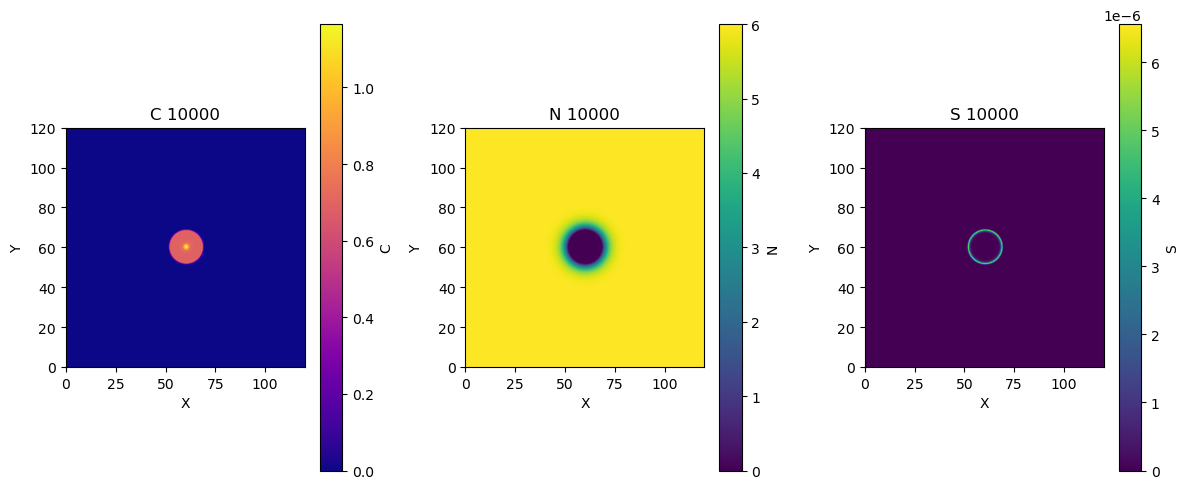

Step 9999: Time = 3.9996, Colony Radius = 8.9655


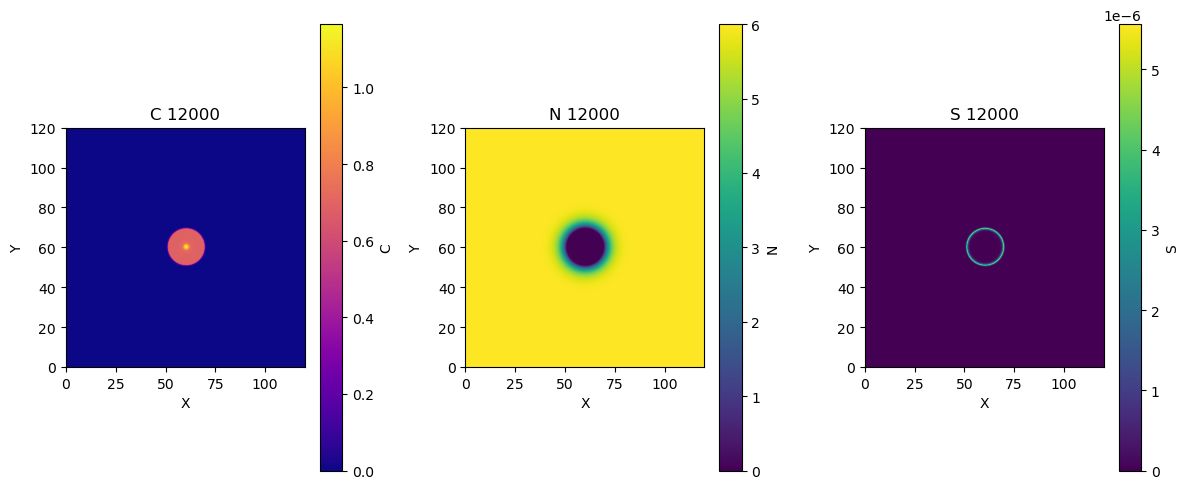

Step 11999: Time = 4.7996, Colony Radius = 9.7467


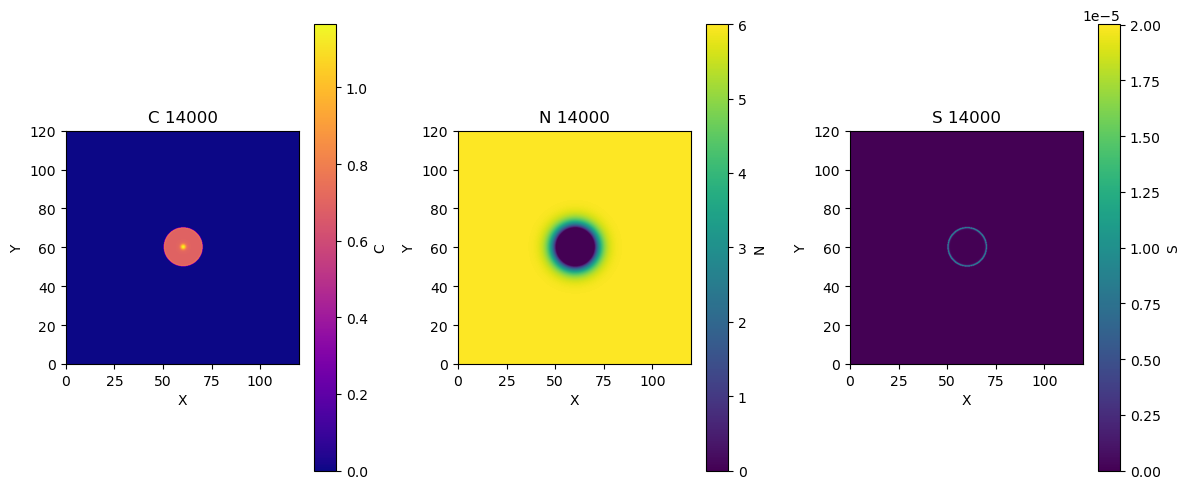

Step 13999: Time = 5.5996, Colony Radius = 10.1509


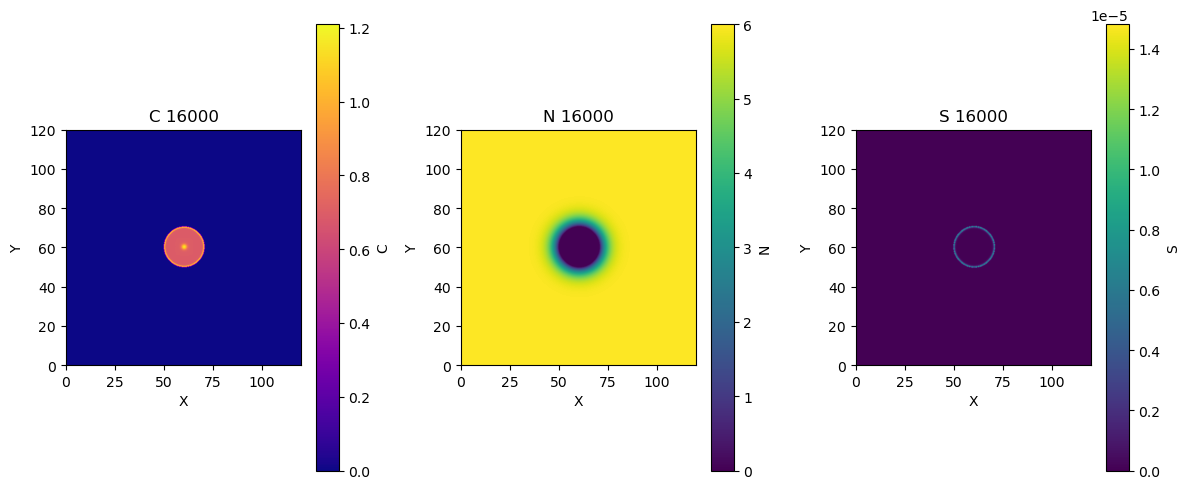

Step 15999: Time = 6.3996, Colony Radius = 10.5926


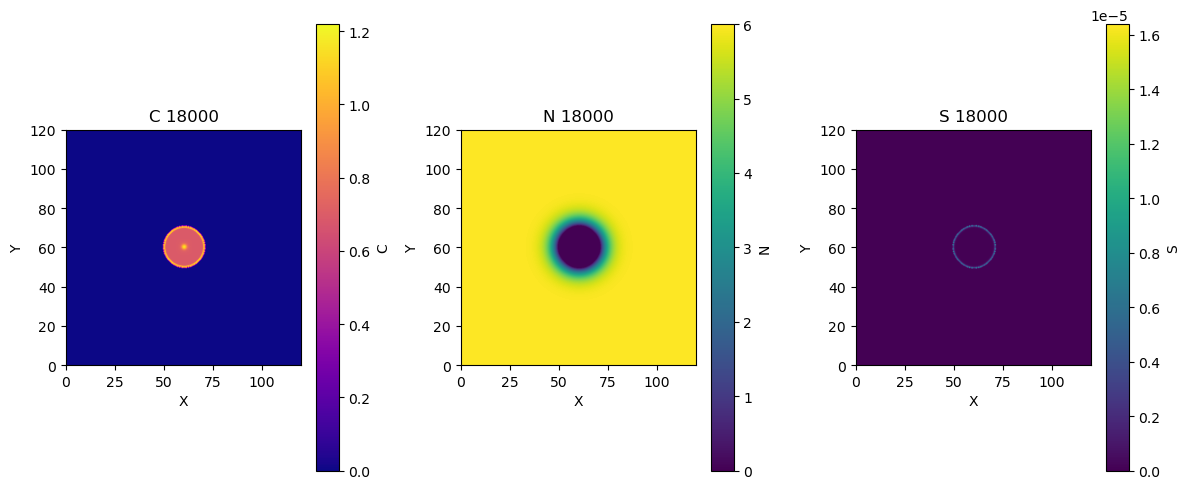

Step 17999: Time = 7.1996, Colony Radius = 11.0039


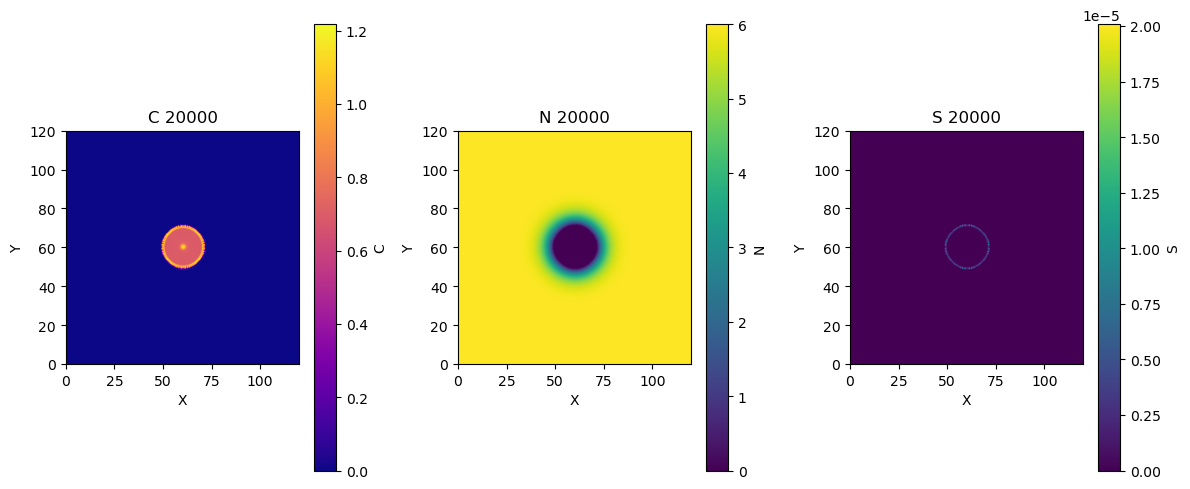

Step 19999: Time = 7.9996, Colony Radius = 11.3481


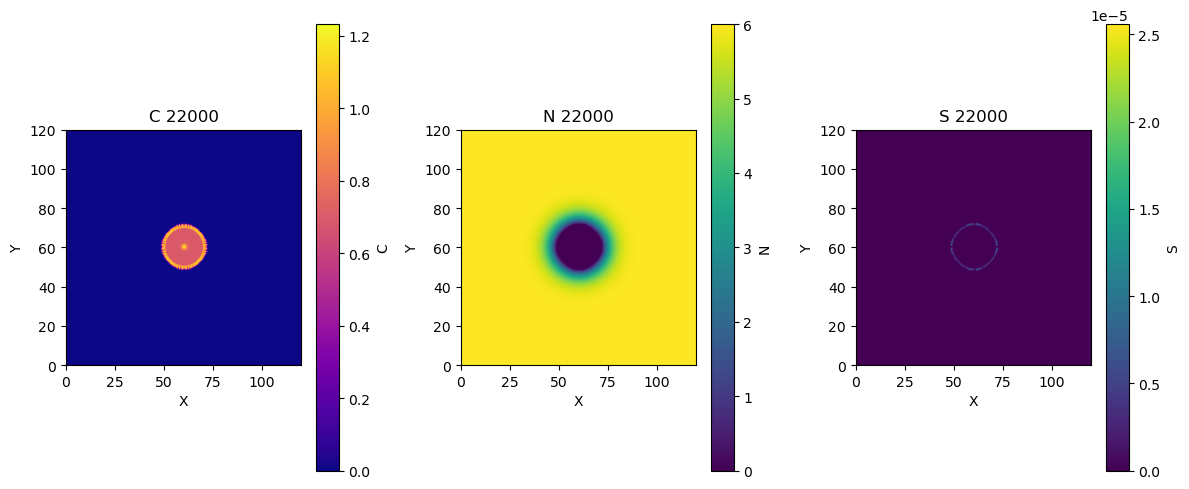

Step 21999: Time = 8.7996, Colony Radius = 11.6941


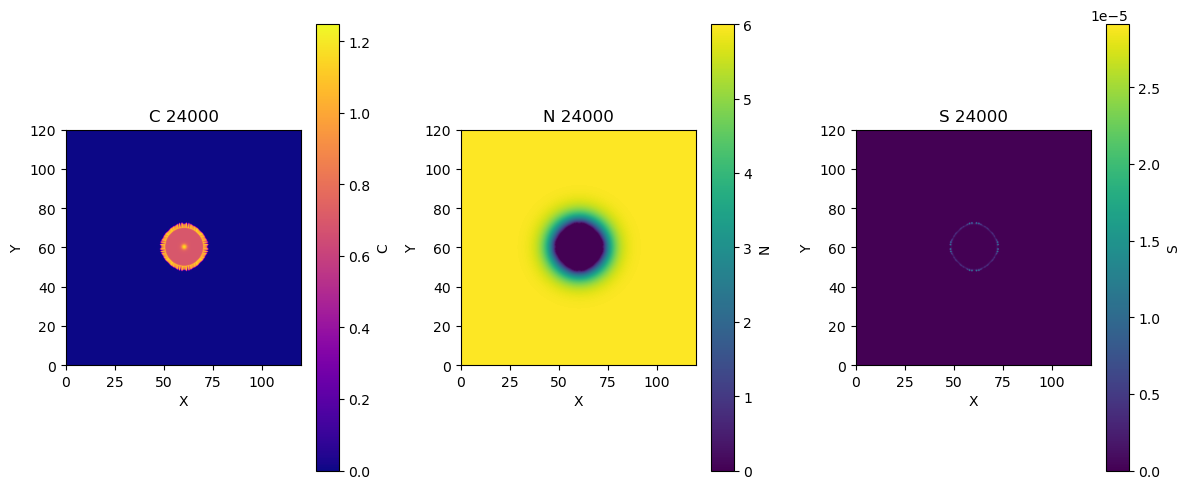

Step 23999: Time = 9.5996, Colony Radius = 12.0563


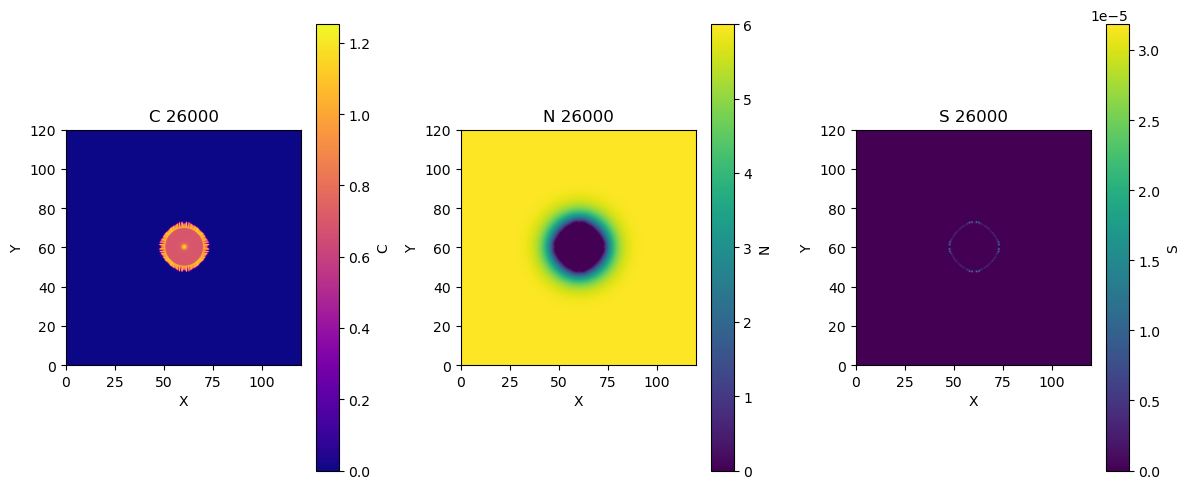

Step 25999: Time = 10.3996, Colony Radius = 12.4291


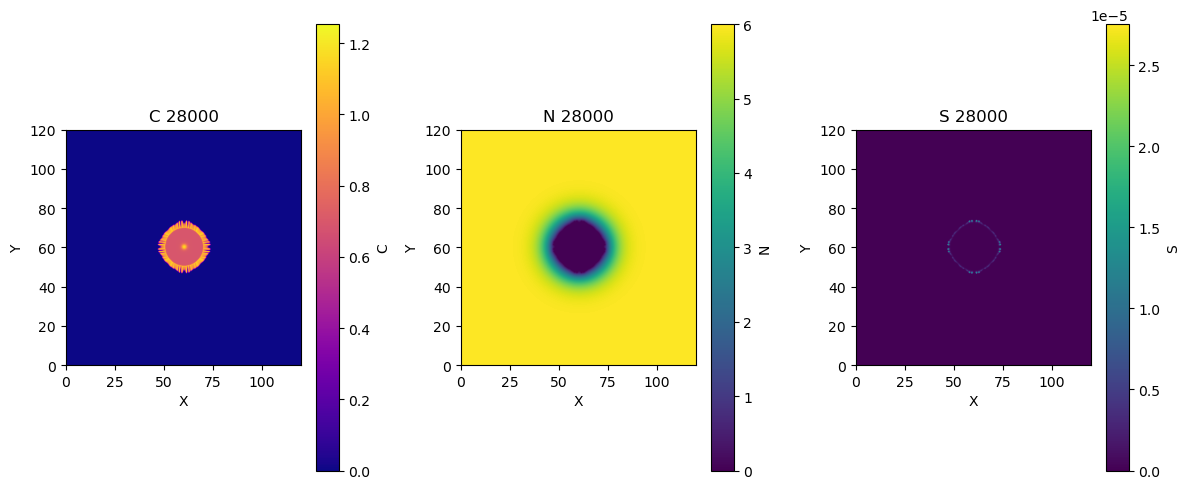

Step 27999: Time = 11.1996, Colony Radius = 12.7801


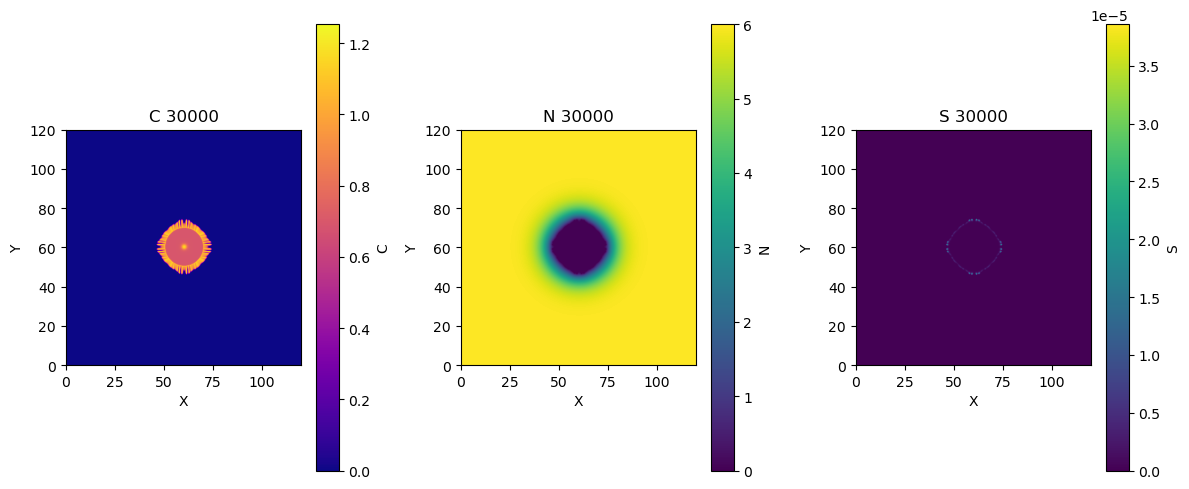

Step 29999: Time = 11.9996, Colony Radius = 13.1176


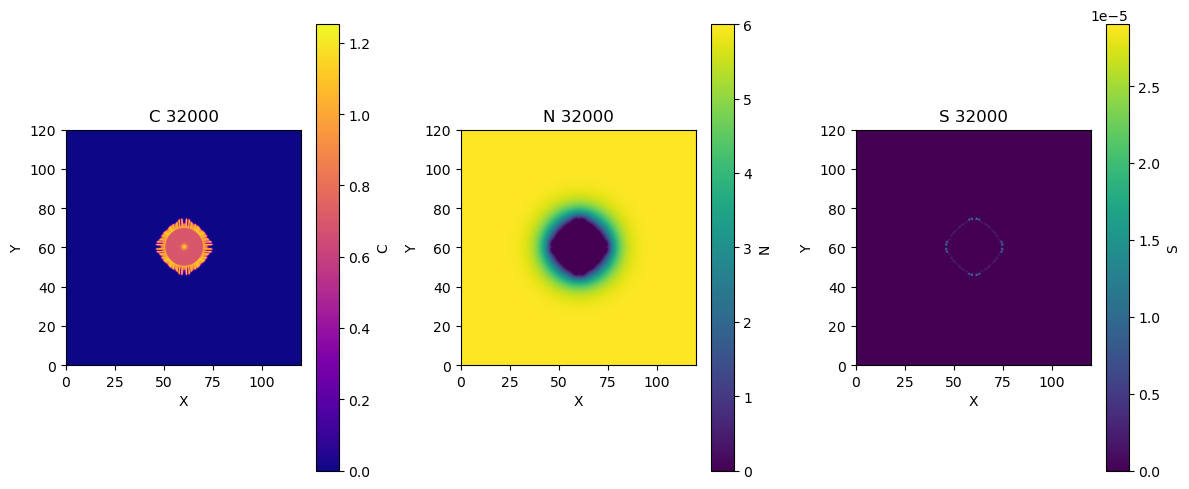

Step 31999: Time = 12.7996, Colony Radius = 13.4714


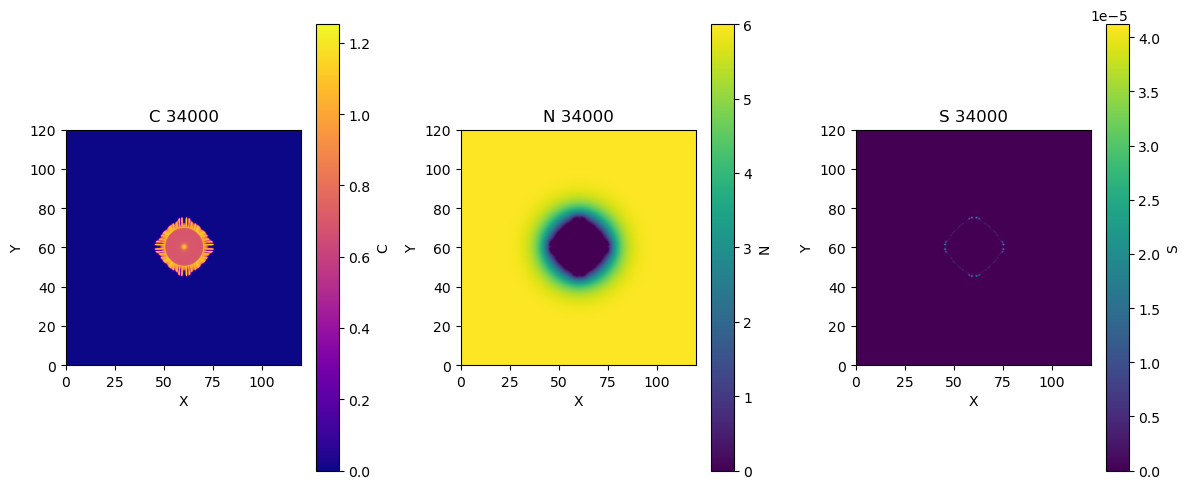

Step 33999: Time = 13.5996, Colony Radius = 13.8149


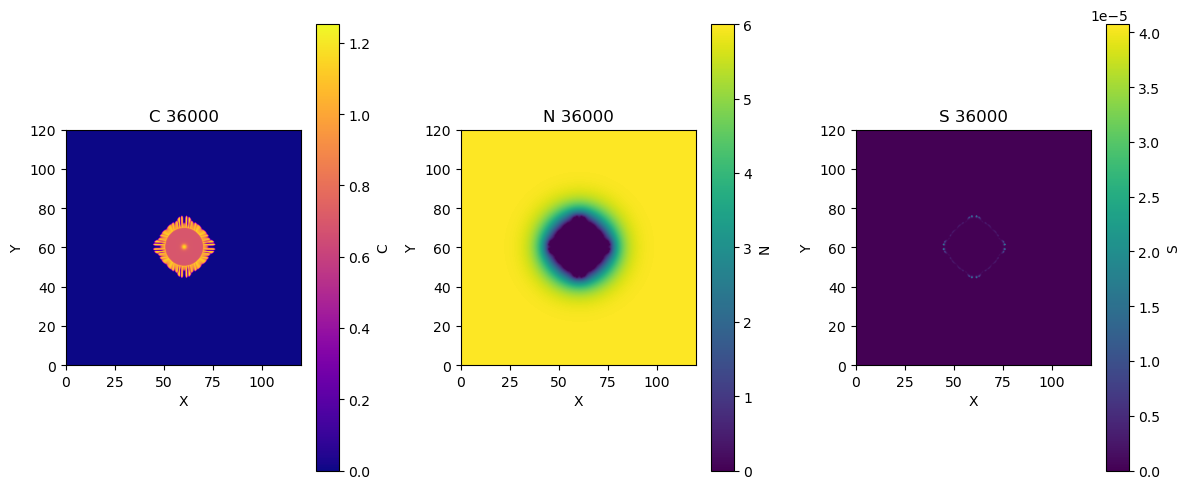

Step 35999: Time = 14.3996, Colony Radius = 14.1315


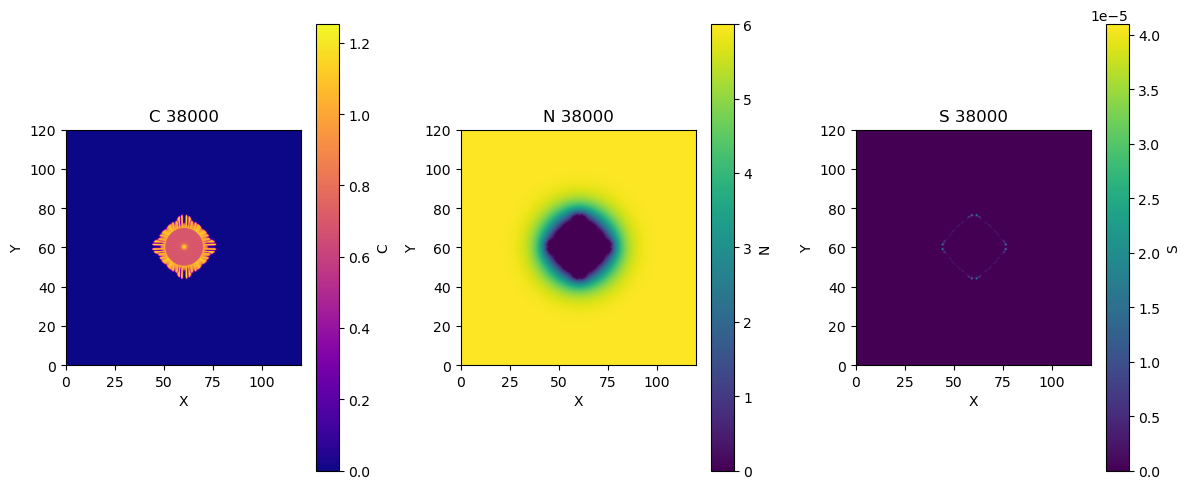

Step 37999: Time = 15.1996, Colony Radius = 14.4684


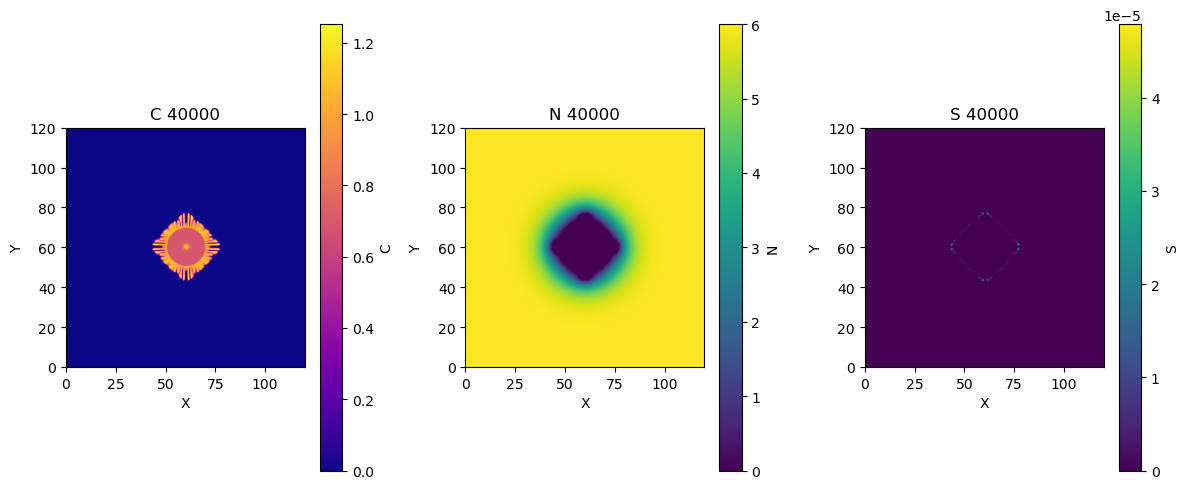

Step 39999: Time = 15.9996, Colony Radius = 14.7863
Simulation completed.


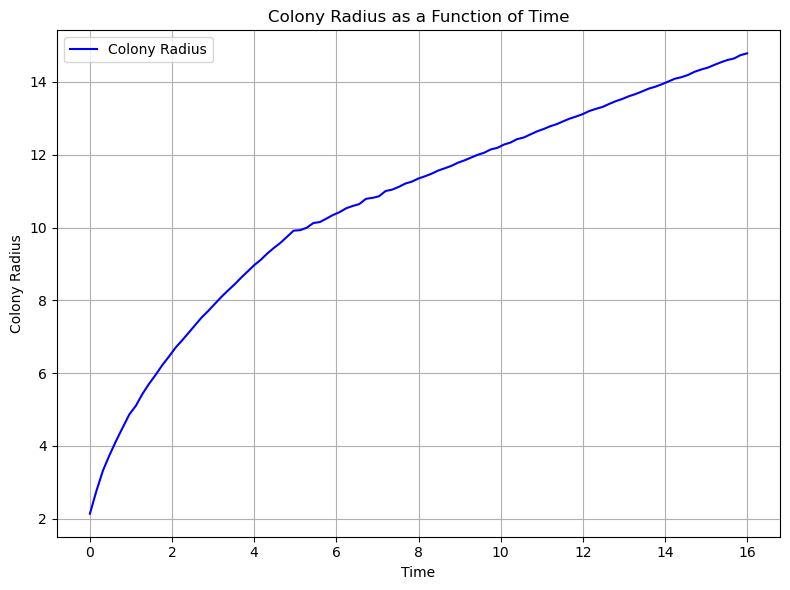

Simulation took 50.72 seconds


In [24]:
import time

#parameters to generate branching
# L = 80
# base parameters (from Nan)
# with modifications aS = 5. 

def run_simulation_fdm():
    """
    Runs the PDE simulation for nutrient concentration (N), proliferating cells (P),
    specialized cells (G), and surfactant (S), using finite difference methods.
    Injects noise into the effective diffusivity D_eff.
    Computes colony area by thresholding C > 0.01 and plots colony radius as a function of time.
    """
    # Define grid parameters
    nx, ny = 512, 512  # Number of grid points (matches MATLAB's nx=401)
    Lx, Ly = 120, 120  # Physical domain size, matching MATLAB's L=20
    dx = Lx / nx
    dy = Ly / ny

    # Define total simulation time and steps
    dt = 4e-4  
    nt = 40000  # Number of time steps
    frames = 20
    samples = 100

    # Define PDE parameters
    # Parameters = [DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP, delta, N0, C0]
    # For demonstration, define Parameters directly as per MATLAB code
    Parameters = [
        5,    # DN = 41.08
        0.2,    # DS = 5.79
        1e3,    # kD 2.58e3
        15,    # bN
        24.24,    # aG
        8.67,    # aP
        75.36,    # kG
        16.98,    # kP
        0.64,   # KN
        6.45,    # KT
        30,    # aS = 1.0
        5,    # bS = 170.52
        6.08,    # KE
        4.55,    # KC
        20,    # Cmax
        2,    # n_param
        2.205,    # d_param
        1.69,    # a_param
        1.84,    # b_param
        2.06,    # KP
        6,    # N0
        1.0     # C0
    ]

    # Extract parameters
    DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP, N0, C0 = Parameters

    print(Parameters)
    # Update pde_params tuple
    pde_params = (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP)

    # Define initial conditions
    R0 = 1.0    # Radius for initial cell concentration, matching MATLAB's exp(- (rr/1)^2 )

    N_initial, P_initial, G_initial, S_initial = initialize_fields(nx, ny, Lx, Ly, N0, C0, R0)
    pde_state = (N_initial, P_initial, G_initial, S_initial)

    # Define noise parameters
    epsilon = 0.2 # Noise amplitude; adjust as needed

    # Initialize PRNG key
    seed = 42  # Arbitrary seed for reproducibility
    key = jax.random.PRNGKey(seed)

    # Initialize lists to store colony radius and time
    colony_radius_list = []
    time_list = []

    # Define threshold for colony
    C_threshold = 0.01

    # Compute cell area
    cell_area = dx * dy

    # Create directory to save outputs (optional)
    save_dir = 'simulation_outputs_fdm'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

#    plt.figure(figsize=(12, 5))
    # Simulation loop
    for step in range(nt):
        # Generate a new random key for this step
        key, subkey = jax.random.split(key)

        # Generate noise: Gaussian noise with mean 0 and standard deviation epsilon
        noise = epsilon * (jax.random.uniform(subkey, shape=(nx, ny)) * 2 - 1)

        # Update PDE state with noise injected into D_eff using FDM
        pde_state, _ = pde_update_fdm(
            pde_state,
            pde_params,
            dx,
            dy,
            dt,
            noise
        )

    
        # Extract updated N, P, G, S
        N, P, G, S = pde_state

        # Compute total cell density C = P + G
        C = P + G

        if (step == 0) or ((step + 1) % (nt//samples) == 0):
            # Compute colony area by thresholding C > C_threshold
            colony_mask = C > C_threshold
            colony_area = jnp.sum(colony_mask) * cell_area

            # Compute colony radius assuming circular colony
            colony_radius = jnp.sqrt(colony_area / jnp.pi)
            colony_radius_list.append(colony_radius)
            time_list.append(step * dt)

        # Optional: Visualization and data saving every 500 steps
        if (step == 0) or ((step+1) % (nt//frames) == 0):
            plt.figure(figsize=(12, 5))

            # Plot C (Total Cell Density)
            plt.subplot(1, 3, 1)
            plt.imshow(C, extent=(0, Lx, 0, Ly), origin='lower', cmap='plasma')
            plt.colorbar(label='C')
            plt.title(f'C {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot N (Nutrient Concentration)
            plt.subplot(1, 3, 2)
            plt.imshow(N, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            plt.colorbar(label='N')
            plt.title(f'N {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot N (Nutrient Concentration)
            plt.subplot(1, 3, 3)
            plt.imshow(S, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            plt.colorbar(label='S')
            plt.title(f'S {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            plt.tight_layout()
            plt.show()
            # Optionally, save the plots
            # plt.savefig(os.path.join(save_dir, f'step_{step}.png'))
            # plt.close()

            # Print progress and colony radius
            print(f"Step {step}: Time = {step*dt:.4f}, Colony Radius = {colony_radius:.4f}")

    print("Simulation completed.")

    # Convert lists to NumPy arrays for plotting
    colony_radius_array = jnp.array(colony_radius_list)
    time_array = jnp.array(time_list)

    # Plot Colony Radius vs Time
    plt.figure(figsize=(8, 6))
    plt.plot(time_array, colony_radius_array, label='Colony Radius', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Colony Radius')
    plt.title('Colony Radius as a Function of Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Optionally, save the plot
    # plt.savefig(os.path.join(save_dir, 'colony_radius_vs_time_fdm.png'))



start = time.time()
run_simulation_fdm()
end = time.time()
print(f"Simulation took {end - start:.2f} seconds")
